# Introduction

This notebook trains a linear discriminant analysis model on preprocessed EEG data to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subject 06 in the NCSL EFRI datasetwill be used in this notebook.

## Imports

In [1]:
import h5py 
import mat73
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_1samp

## Load File Paths

In [2]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
ncsl_share = '/mnt/ncsl_share'
data_path = ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject06_snapshot_normalized.npy'
setup_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Setup.mat'
raw_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Raw.mat'
out_path_tvalues = f't_values'

raw_file = h5py.File(raw_path)
setup_data = mat73.loadmat(setup_path)

In [95]:
setup_data.keys()

dict_keys(['elec_area', 'elec_ind', 'elec_name', 'filters', 'trial_times', 'trial_words'])

## Instantiate variables

In [3]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [4]:
elec_names = np.array(setup_data['elec_name'])
elec_areas = np.array(setup_data['elec_area'])

In [5]:
data = np.load(data_path)
num_trials, num_channels, num_freqs, num_timesteps = data.shape

In [6]:
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

## Model Training

Using the power per wavelet scale for a particular channel and timepoint as a feature. 

In [108]:
def train_LDA_model(data, y, channel, time, time_resolution):

    # Checks that inputted value for time resolution is valid
    if not(num_timesteps % time_resolution == 0):
            raise Exception("Invalid time resolution size, num_timesteps % resolution > 0")
    
    X = data[:, channel, :, time:time+time_resolution].mean(2) 

    low_bet_avg_power = X[np.where(y == 0), :][0]
    high_bet_avg_power = X[np.where(y == 1), :][0] 

    # # Using RepeatedKFold() for training LDA
    # rkf = RepeatedKFold(n_splits=5, n_repeats=1)

    # estimators = []
    # scores = []

    # for train, test in rkf.split(X):
    #     lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    #     lda.fit(X[train], y[train])
    #     estimators.append(lda)
    #     scores.append(lda.score(X[test], y[test]))    

    # Using cross_validate() function for training LDA
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    cv_results = cross_validate(lda, X, y, cv = 5, return_estimator=True)

    estimators = cv_results['estimator']
    scores = cv_results['test_score']

    best_score = max(scores)
    best_index = list(scores).index(best_score)
    best_lda = estimators[best_index] # select the best performing model after cross-validation

    dval = np.dot(X, best_lda.coef_.T).T[0] + best_lda.intercept_ # calculate decision value 

    t_stat = ttest_1samp(dval, popmean=0).statistic # perform 1-sided t-test on decision values corresponding to high bet
    return best_score, dval, t_stat, low_bet_avg_power, high_bet_avg_power

In [72]:
best_score, dval, t_stat, bet_avg_powers = train_LDA_model(data,y,0,0,10)

In [74]:
bet_avg_powers[0].shape

(110, 63)

In [112]:
# Code to train LDA model for all channels and timepoints for Subject 6
time_resolution = 2
rescaled_timesteps = int(num_timesteps/time_resolution)

# A dictionary that stores all the metrics of the LDA model
metrics = {
    'Best Scores' : np.zeros((num_channels, rescaled_timesteps)),
    'Decision Values' : np.zeros((num_channels, rescaled_timesteps, num_trials)),
    'T Stats' : np.zeros((num_channels,rescaled_timesteps)),
    'Low Bet Average Powers' : np.zeros((num_channels, rescaled_timesteps, len(y) - y.sum(), num_freqs)),
    'High Bet Average Powers' : np.zeros((num_channels, rescaled_timesteps, y.sum(), num_freqs))
}

# dvals = np.zeros((num_channels, rescaled_timesteps, num_trials))
# t_stats = np.zeros((num_channels,rescaled_timesteps))
# best_scores = np.zeros((num_channels, rescaled_timesteps))
# low_bet_avg_powers = np.zeros((rescaled_timesteps, len(y) - y.sum(), num_freqs))
# high_bet_avg_powers = np.zeros((rescaled_timesteps, y.sum(), num_freqs))

for channel in range(num_channels):
    for time in range(rescaled_timesteps):
        # best_scores[channel, time], dvals[:, time], t_stats[channel,time], low_bet_avg_powers[time,:,:], high_bet_avg_powers[time,:,:] = train_LDA_model(data=data, y=y, channel=channel, time=time*time_resolution, time_resolution=time_resolution)
        metrics['Best Scores'][channel, time], metrics['Decision Values'][:, time], metrics['T Stats'][channel, time], metrics['Low Bet Average Powers'][channel, time], metrics['High Bet Average Powers'][channel, time] = train_LDA_model(data=data, y=y, channel=channel, time=time*time_resolution, time_resolution=time_resolution)

In [101]:
metrics['Low Bet Average Powers'].shape

(133, 50, 110, 63)

### Reshuffling of Data

In [8]:
# Returns an array with shuffled y-values, ensures that high bet ratio is consistent with thay expected for the particular card value

def shuffle_y(y):
    # Get the locations for each particular card value
    card_value_indices = []
    for i in [2,4,6,8,10]:
        card_value_indices.append(np.where(subject_cards == i)[0])

    y_shuffled = np.zeros(y.shape)

    # Ensure that the number of high bets in the shuffled y labels is consistent with the card value
    for indices in card_value_indices:
        temp = indices
        num_high_bets = y[indices].sum() + round(np.random.uniform(-1,1)*y[indices].sum()*0.2) # Get the number of high bets for a particular card value and add some randomness to it
        for j in range(num_high_bets):
            if np.any(temp):
                # Pick a random location from all possible locations of that particular card value and set it to 1 (ie high bet)
                rand = np.random.choice(temp)
                y_shuffled[rand] = 1
                rand_index = np.where(temp == rand)[0]
                temp = np.delete(temp,rand_index) # Remove that location from being able to be chosen again
        y_shuffled[temp] = 0 # set all other locations for that particular card value to 0 (ie low bet)

    return y_shuffled

## Multiprocessing

In [36]:
def get_shuffled_t_stats(data, y, num_channels, num_timesteps, num_trials):
    np.random.seed()
    time_resolution = 2
    rescaled_timesteps = int(num_timesteps/time_resolution)

    dvals = np.zeros((num_channels, rescaled_timesteps, num_trials))
    t_stats = np.zeros((num_channels,rescaled_timesteps))
    best_scores = np.zeros((num_channels, rescaled_timesteps))
    bet_avg_power = np.zeros((2, num_freqs, rescaled_timesteps))
    
    y_shuffled = shuffle_y(y)
    
    for channel in range(num_channels):
        for time in range(num_timesteps):
          best_scores[channel,time], dvals[:,time], t_stats[channel,time], bet_avg_power[:,time] = train_LDA_model(data, y_shuffled, channel, time)
    
    return t_stats

In [289]:
from multiprocessing import Pool

n_processes = 3

if __name__ == '__main__':
    with Pool(n_processes) as p:
        results = p.starmap(get_shuffled_t_stats, [(data, y, num_channels, num_timesteps, num_trials)] * 2)
        p.close()

KeyboardInterrupt: 

In [ ]:
import multiprocessing
n_processes = 2
pool = multiprocessing.Pool(processes= n_processes)
results = pool.starmap(get_shuffled_t_stats, [(data, y, num_channels, num_timesteps, num_trials)] * 2)
pool.close()

In [10]:
sub6_shuffled_t_stats = np.load('t_values/Subject06_shuffled_tvalues.npy')

In [11]:
sub6_shuffled_t_stats.shape

(100, 133, 100)

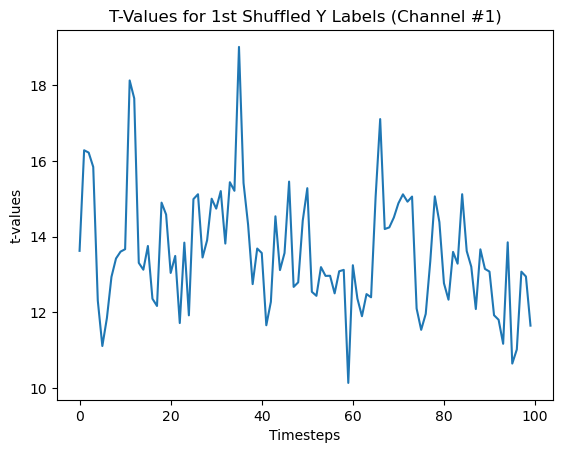

In [12]:
plt.plot(sub6_shuffled_t_stats[0][0])
plt.xlabel('Timesteps')
plt.ylabel('t-values')
plt.title('T-Values for 1st Shuffled Y Labels (Channel #1)')
plt.show()

In [13]:
sub6_t_stats = np.load('t_values/Subject06_tvalues.npy')

In [11]:
sub6_t_stats.shape

(133, 100)

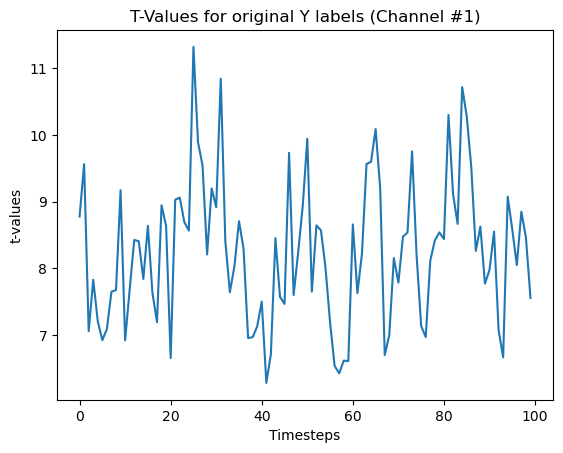

In [15]:
plt.plot(sub6_t_stats[0])
plt.xlabel('Timesteps')
plt.ylabel('t-values')
plt.title('T-Values for original Y labels (Channel #1)')
plt.show()

# Visualization of the Accuracy of the Models

In [9]:
def plot_sorted_scores(best_scores_max_sorted):
    fig, axs = plt.subplots(3, 1, figsize=(24, 18))

    axs[0].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
    axs[0].set_ylabel('Peak Accuracy')
    axs[0].set_xlabel('Channels (from most to least accurate)')
    axs[0].plot(best_scores_max_sorted[:,2])

    axs[1].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
    axs[1].set_ylabel('Peak Accuracy')
    axs[1].set_xlabel('Channels (from most to least accurate)')
    axs[1].bar(np.arange(0,num_channels), best_scores_max_sorted[:,2])
    axs[1].set_ylim(min(best_scores_max_sorted[:,2]) - 0.025, max(best_scores_max_sorted[:,2]) + 0.025)

    axs[2].set_title('Time of Peak Score of LDA Models')
    axs[2].set_ylabel('Time (seconds)')
    axs[2].set_xlabel('Channels (from most to least accurate)')
    time = best_scores_max_sorted[:,1]/(20/time_resolution) -3
    axs[2].scatter(np.arange(0, num_channels), time)
    
    plt.savefig('accuracy_plots/sorted_accuracies.png')
    plt.show()

In [93]:
# Plots the model accuracy as a function of time for the top performing channels, number of plots specified by "num_plots"
def plot_sorted_scores_per_channel(num_plots, metrics, best_scores_max_sorted):
    fig, axs = plt.subplots(num_plots, 1, figsize=(24, 6 * num_plots))

    times = (np.arange(0, 100/time_resolution, 1) / (20/time_resolution)) - 3 # time 0 seconds denotes when the subject starts moving 

    for i, trial_data in enumerate(best_scores_max_sorted[:num_plots]):
        channel, time, peak_accuracy = trial_data
        time = time/(20/time_resolution) - 3
        ax = axs[i]
        ax.plot(times[:], metrics['Best Scores'][int(channel)])
        ax.set_title('Electrode %s in the %s' %(elec_names[int(channel)], elec_areas[int(channel)]))
        ax.set_ylabel('Score')
        ax.set_xlabel('Time (seconds)')
        ax.axvspan(time - .0025 ,time + .0025, color = 'red', alpha=0.5)
        ax.annotate(f'(Time: {time:.2f}s, Score: {peak_accuracy:.2f})', xy=(time + .05 ,.6))
    
    plt.savefig('accuracy_plots/accuracies_line.png')
    plt.show()

In [98]:
def plot_power_heatmap(data, num_plots, metrics, best_scores_max_sorted):
    num_x_ticks = 21
    num_y_ticks = 10

    yticklabels = np.logspace(np.log2(2),np.log2(150),num=num_y_ticks,base=2, dtype=np.int_)
    xticklabels = np.linspace(0, rescaled_timesteps, num=num_x_ticks, dtype=np.float16)/(20/time_resolution) - 3

    for i, elem in enumerate(xticklabels):
        xticklabels[i] = round(elem,1)

    yticks = np.linspace(0, num_freqs, num_y_ticks)
    xticks = np.linspace(0, num_timesteps, num_x_ticks)

    for i, trial_data in enumerate(best_scores_max_sorted[:num_plots]):
        channel, time, peak_accuracy = trial_data

        low_bet_powers = metrics['Low Bet Average Powers'][int(channel), int(time)]
        high_bet_powers = metrics['High Bet Average Powers'][int(channel), int(time)]

        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24, 8))
        sns.heatmap(low_bet_powers.T, ax=ax1, vmin=-5, vmax=5)
        ax1.set_title('Electrode %s in the %s: Low Bet Frequency Power' %(elec_names[int(channel)], elec_areas[int(channel)]))

        sns.heatmap(high_bet_powers.T, ax=ax2, vmin=-5, vmax=5)
        ax2.set_title('Electrode %s in the %s: High Bet Frequency Power' %(elec_names[int(channel)], elec_areas[int(channel)]))

        for ax in (ax1,ax2):
            ax.axes.invert_yaxis()
            # ax.set_xticks(xticks)
            # ax.set_xticklabels(xticklabels)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels)
            ax.set(xlabel="Trial Indices", ylabel="Frequency (Hz)")

        # TODO: Add line graph on top of heatmap
        # sns.lineplot(x=np.arange(0,100), y=t_stats[0])

In [99]:
def plot_scores(num_channels, metrics):
    best_scores_max = np.zeros((num_channels,3))

    for channel in range(num_channels):
        best_scores_max[channel, 0] = channel # store the channel index
        best_scores_max[channel, 1] = list(metrics['Best Scores'][channel]).index(max(metrics['Best Scores'][channel])) # the time point at which the maximum accuracy occurs
        best_scores_max[channel, 2] = max(metrics['Best Scores'][channel]) # value of the max score in a particular channel for all time points

    best_scores_max_sorted = best_scores_max[best_scores_max[:,2].argsort()[::-1]]
    
    elec_names_sorted = elec_names[best_scores_max[:,2].argsort()[::-1]]
    elec_areas_sorted = elec_areas[best_scores_max[:,2].argsort()[::-1]]

    plot_sorted_scores(best_scores_max_sorted)
    plot_sorted_scores_per_channel(10, metrics, best_scores_max_sorted)
    plot_power_heatmap(data, 10, metrics=metrics, best_scores_max_sorted=best_scores_max_sorted)

    return (elec_names_sorted, elec_areas_sorted)

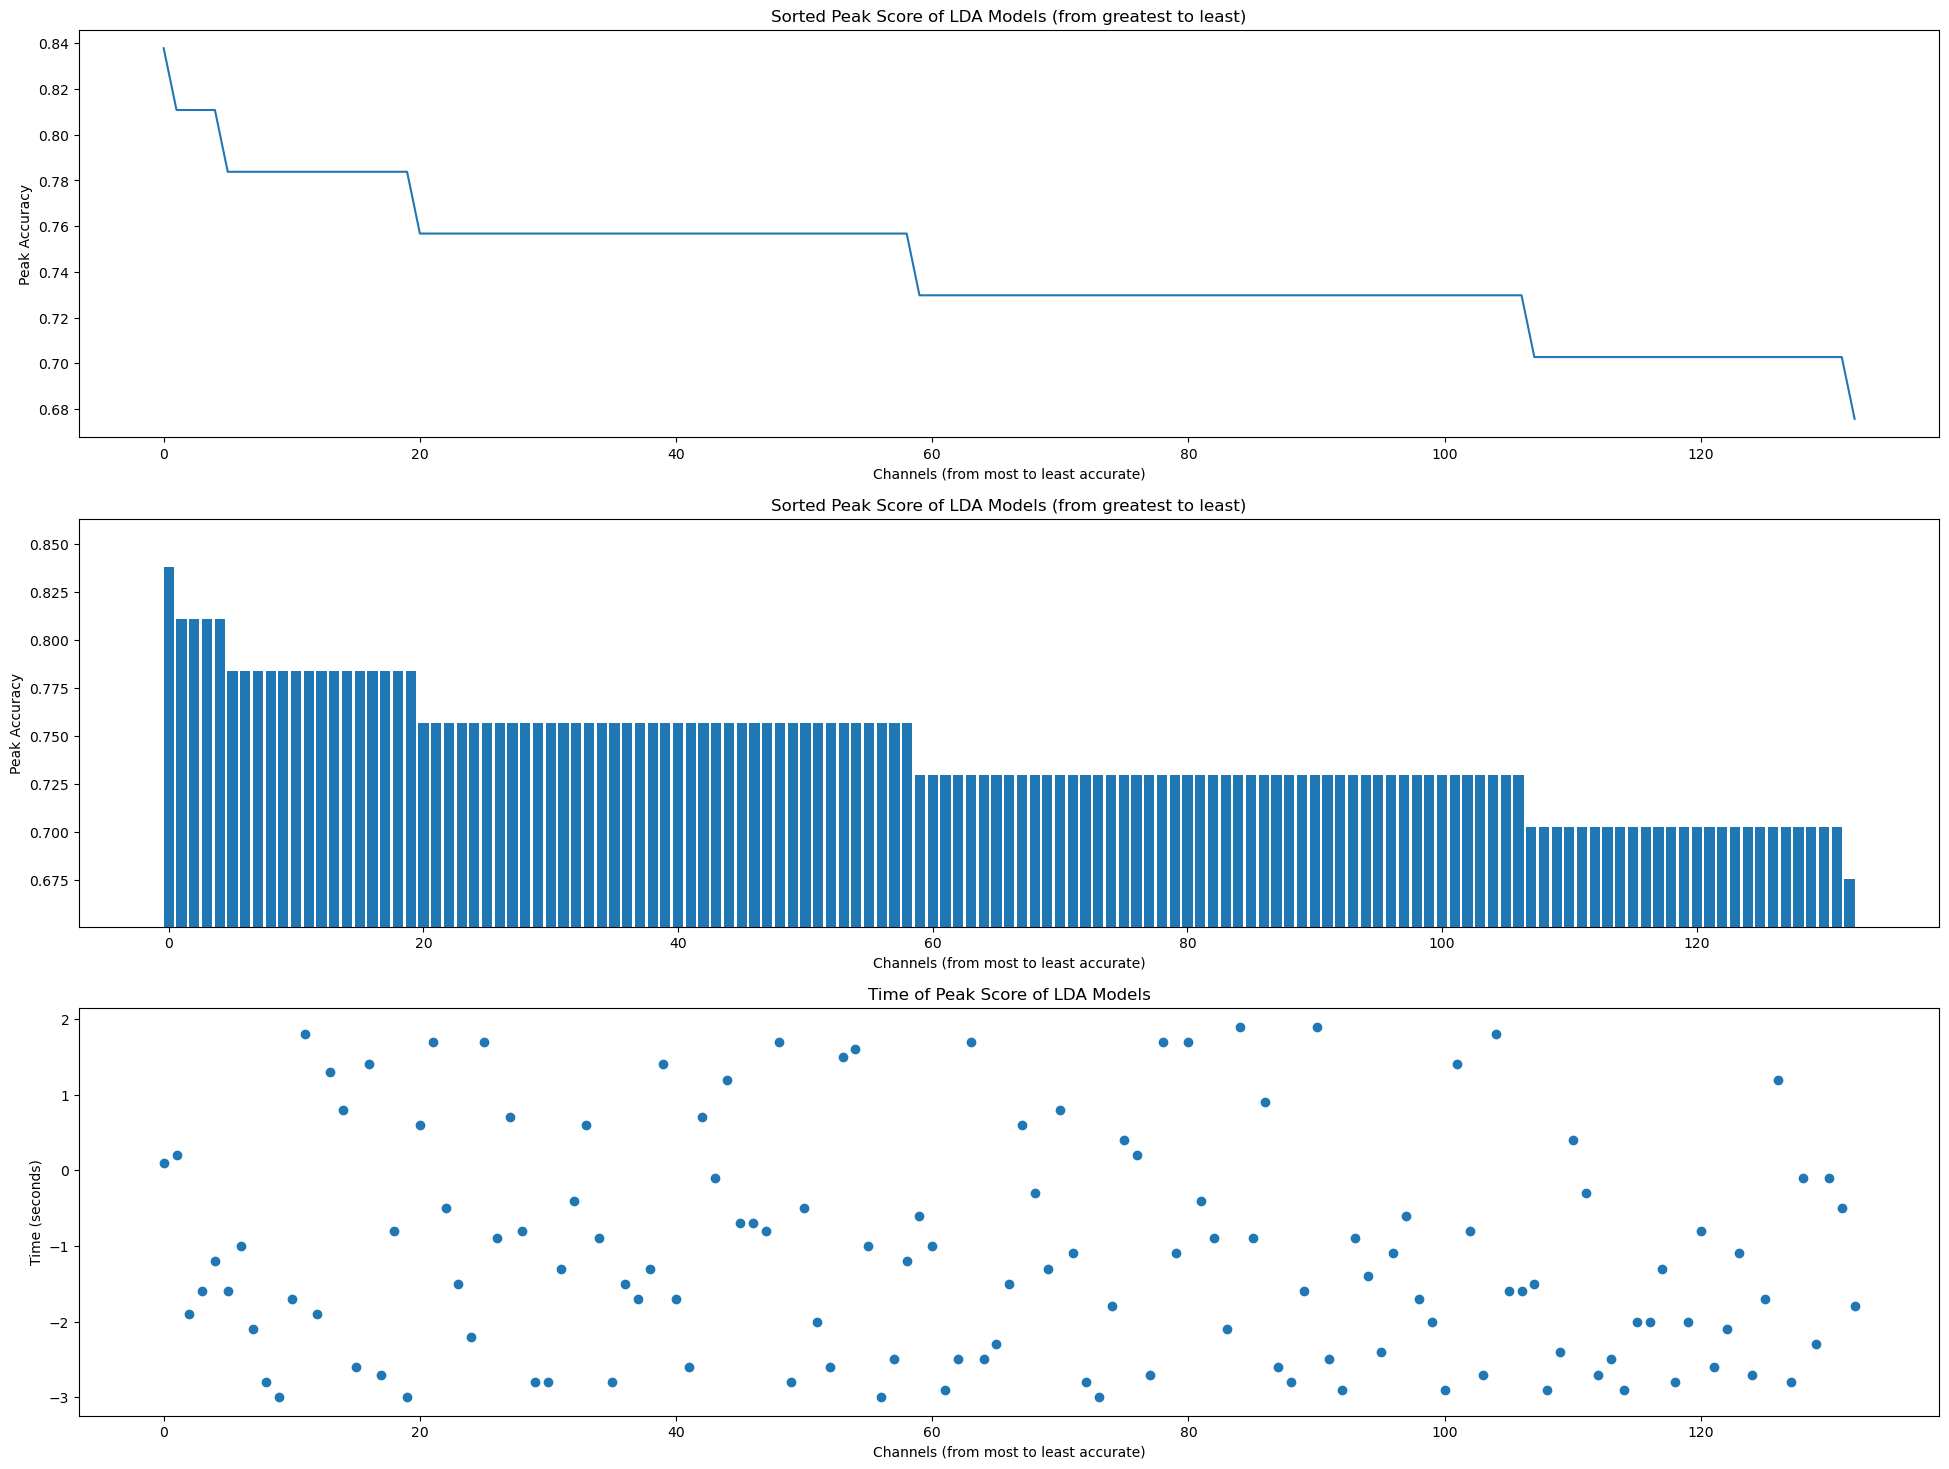

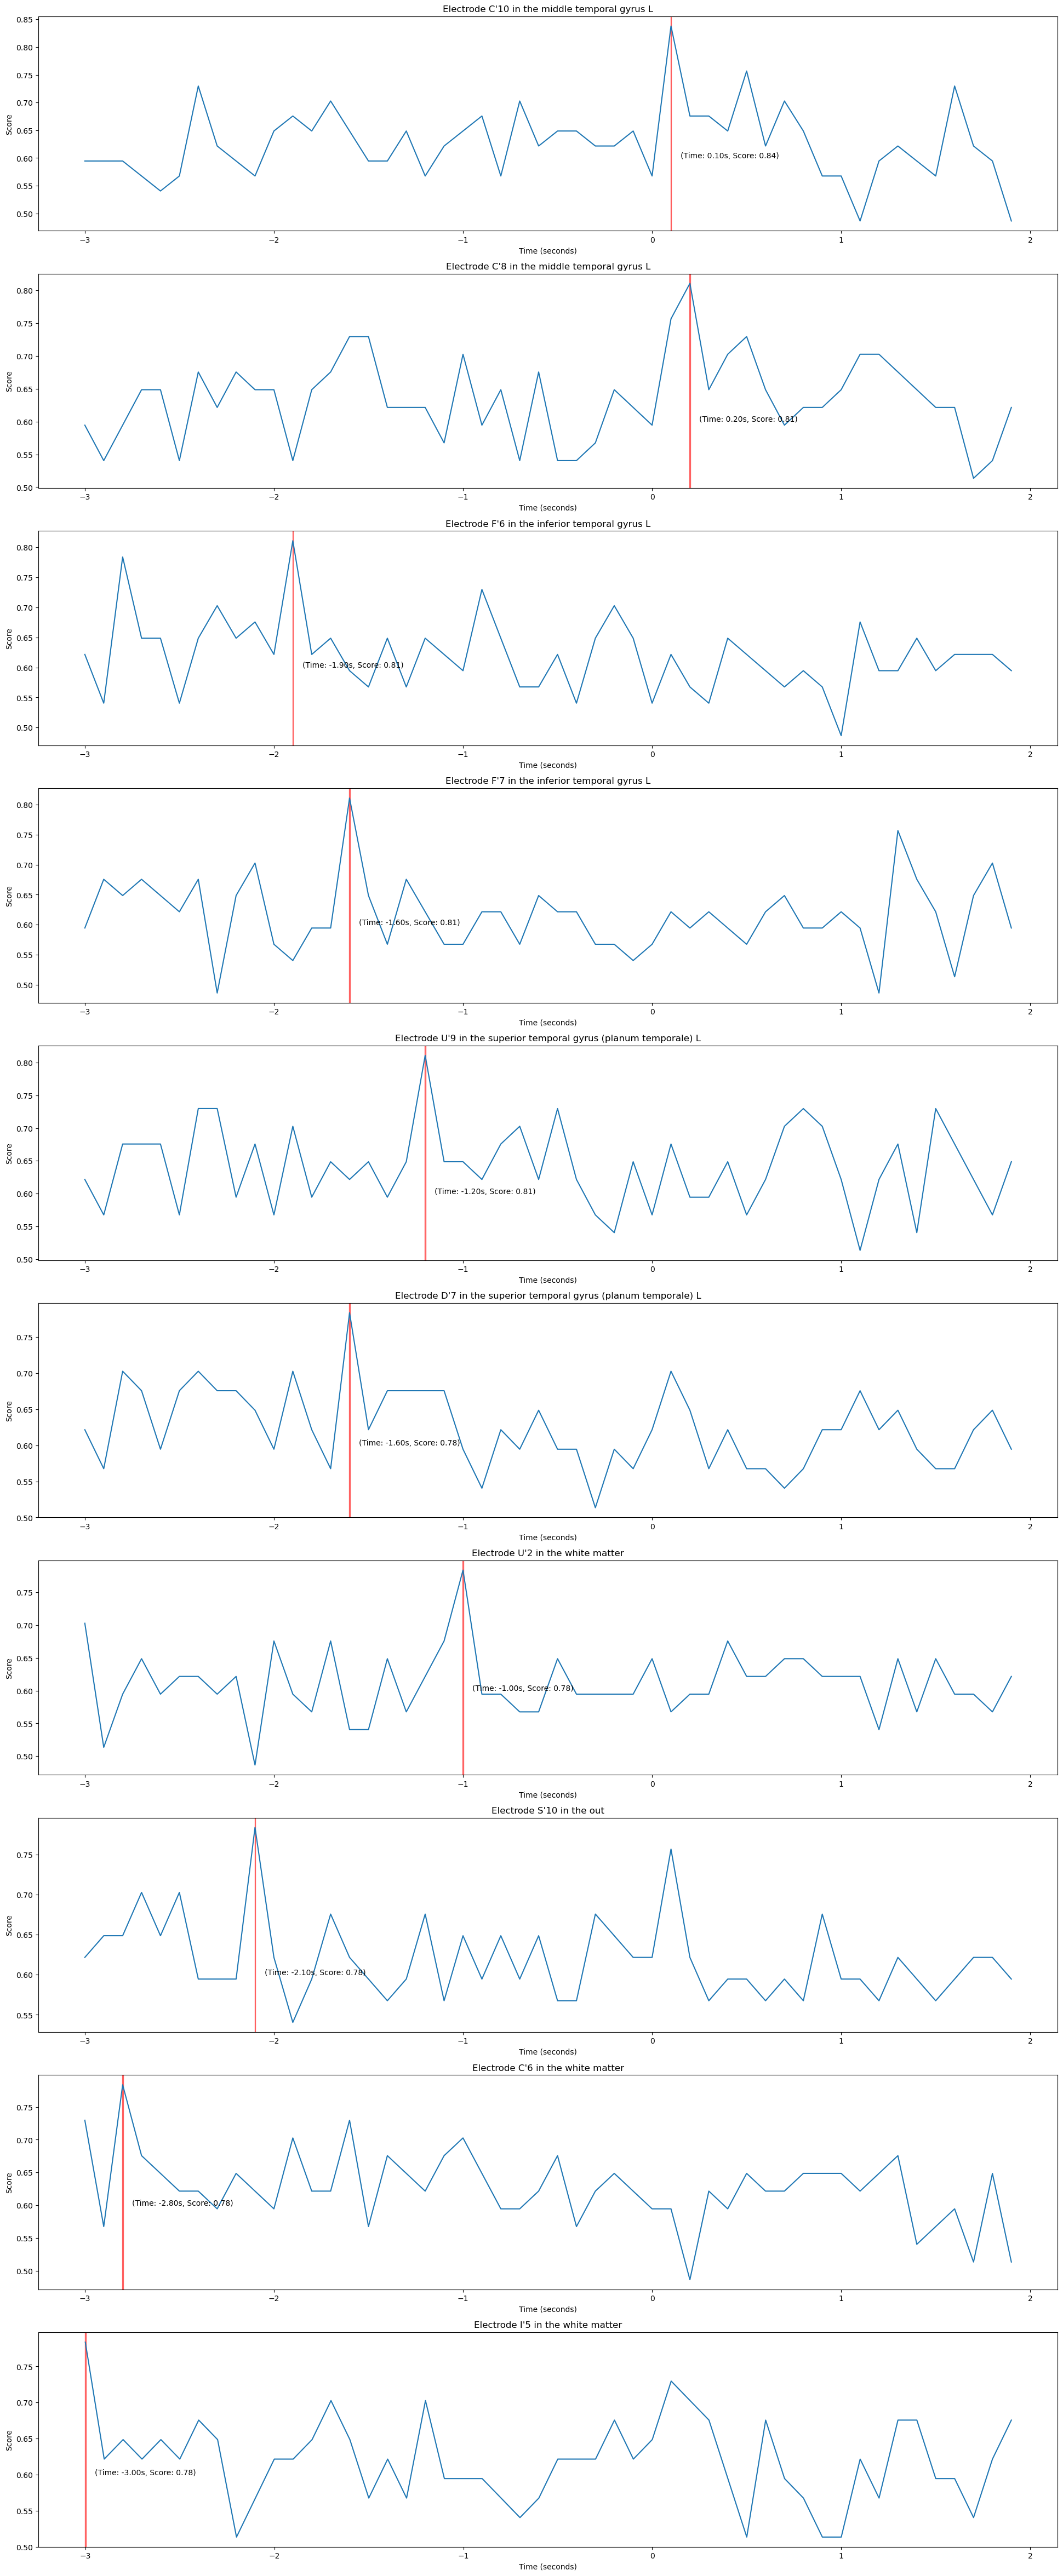

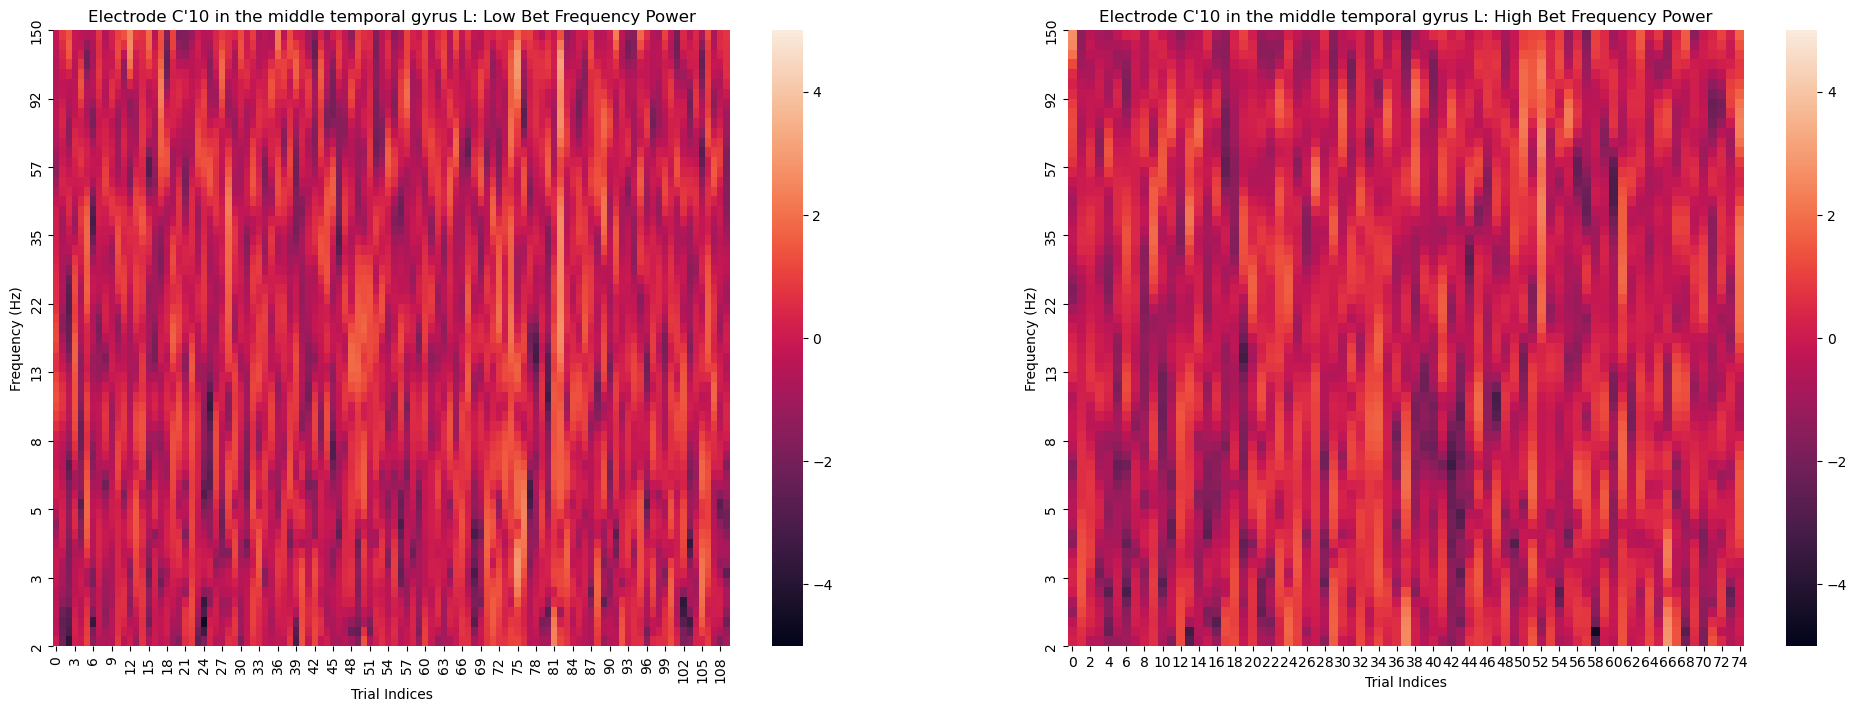

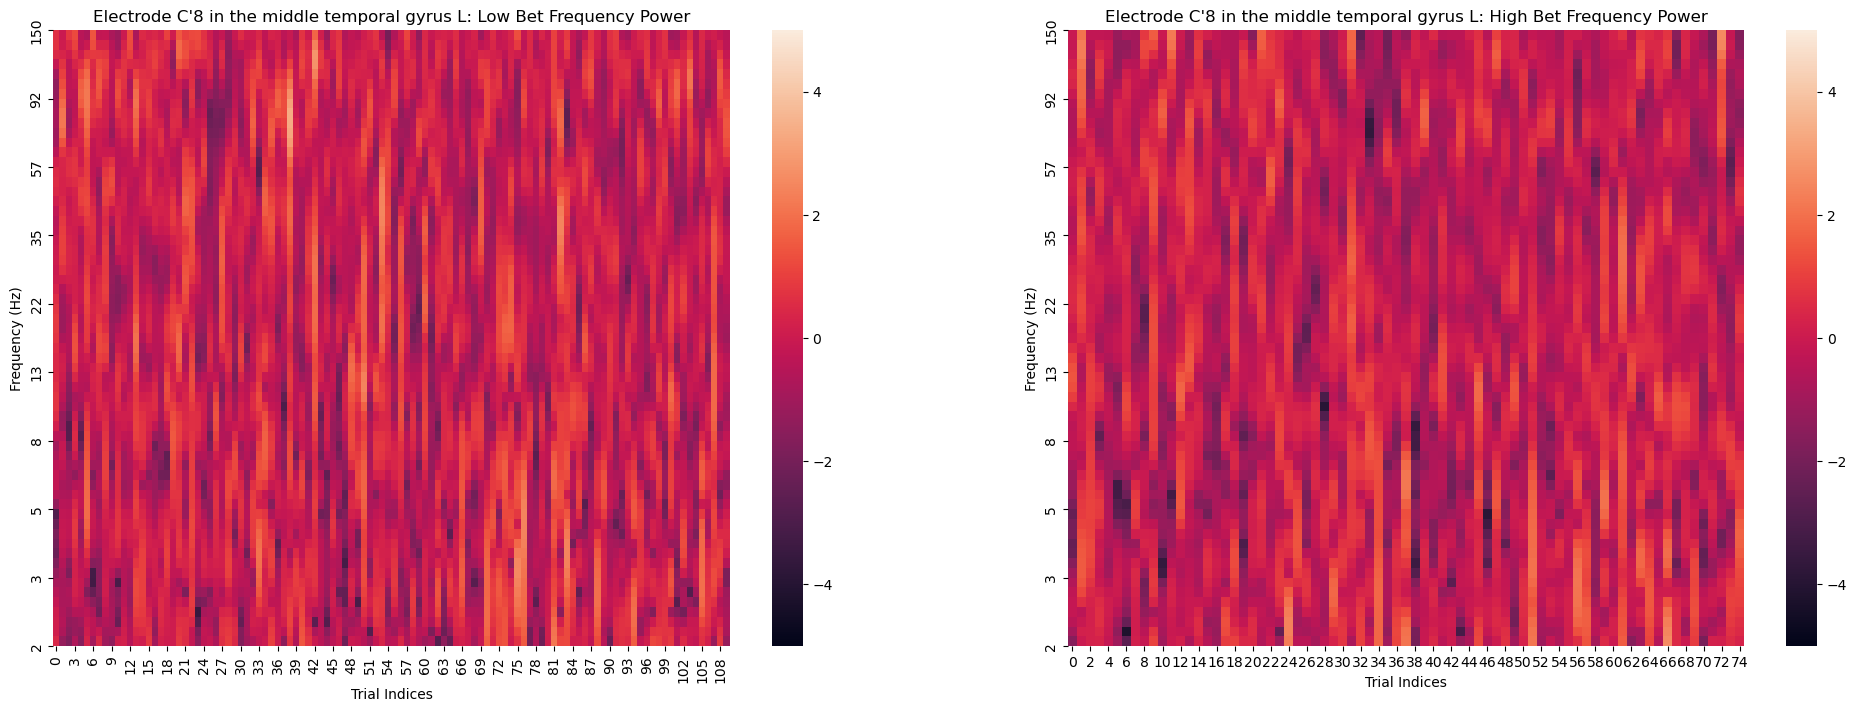

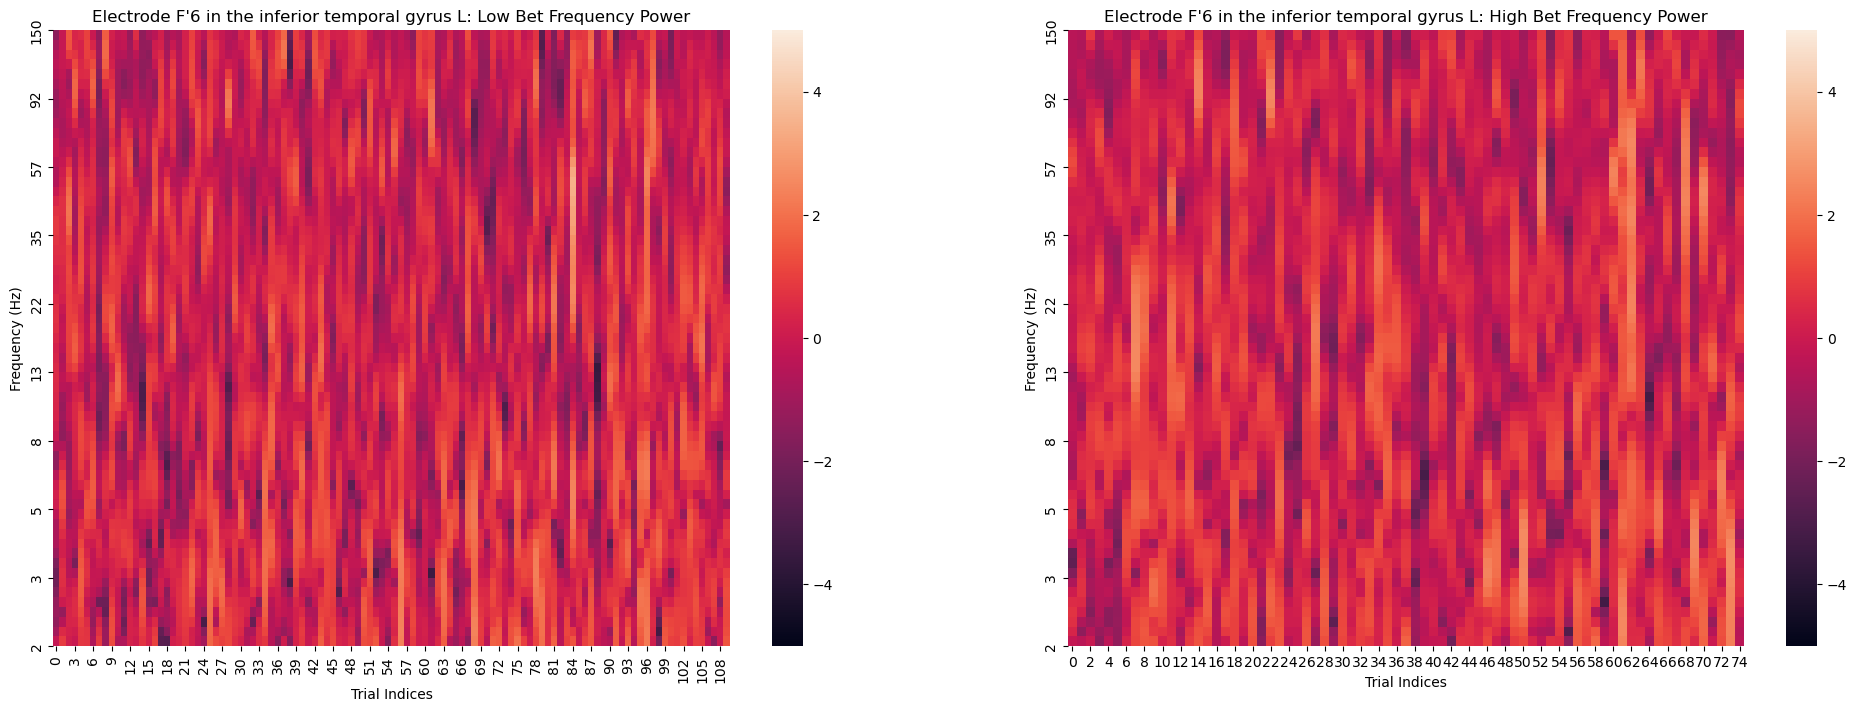

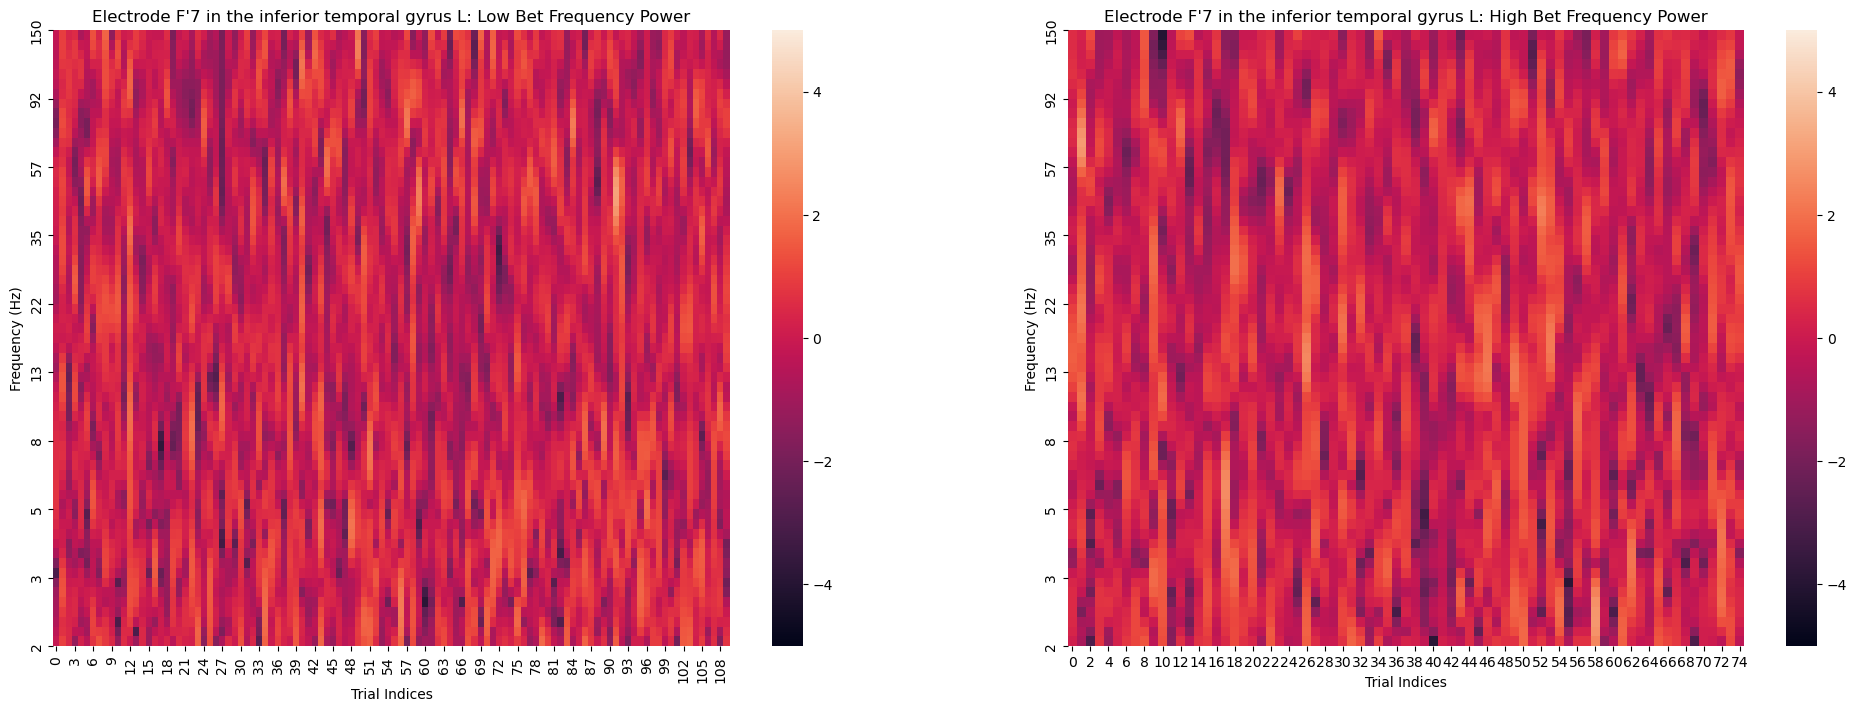

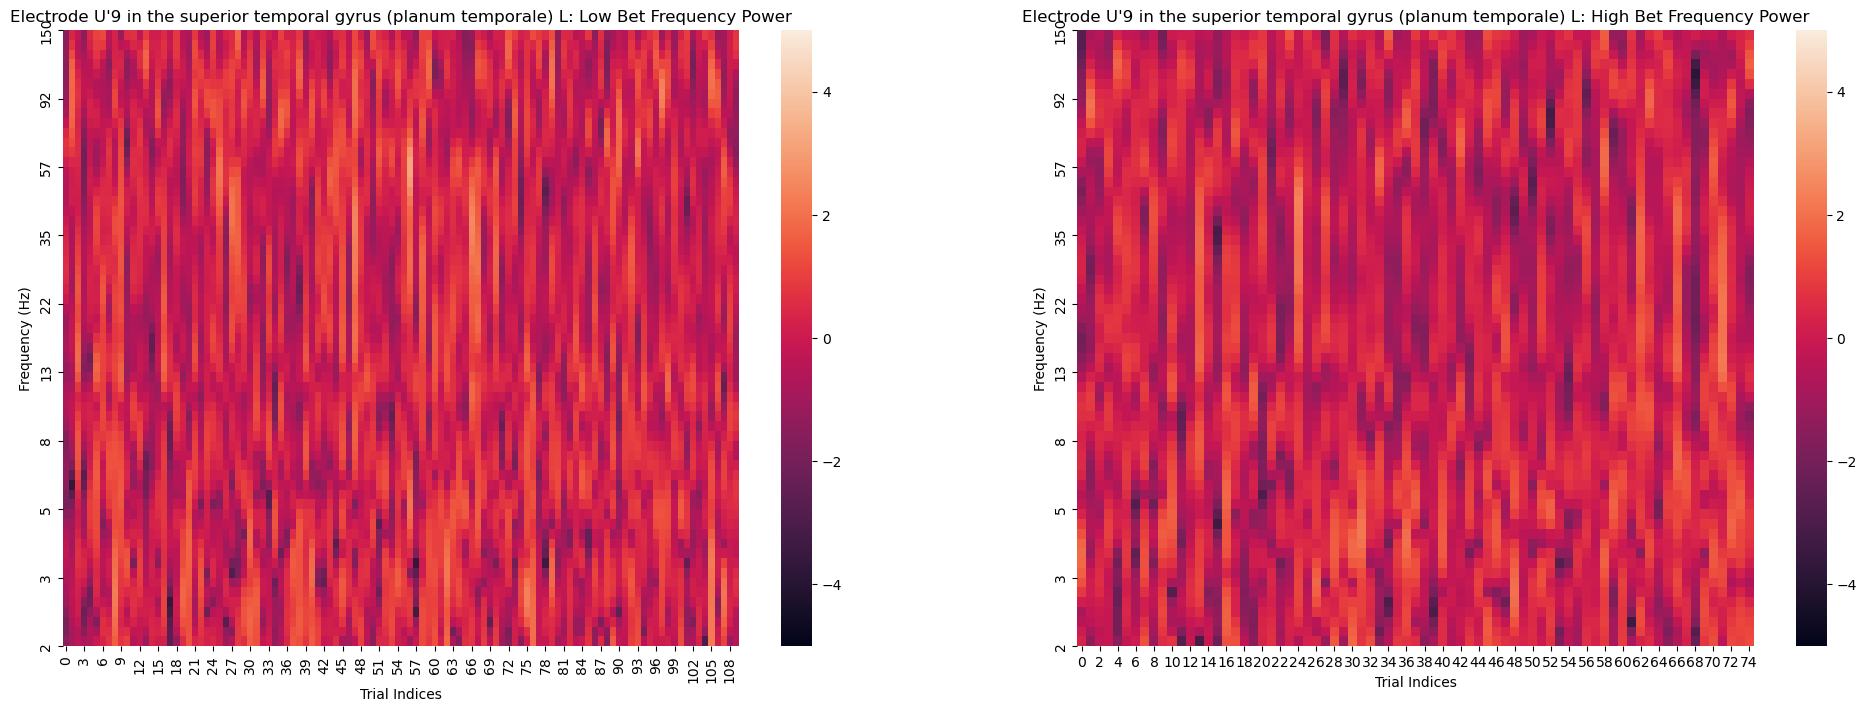

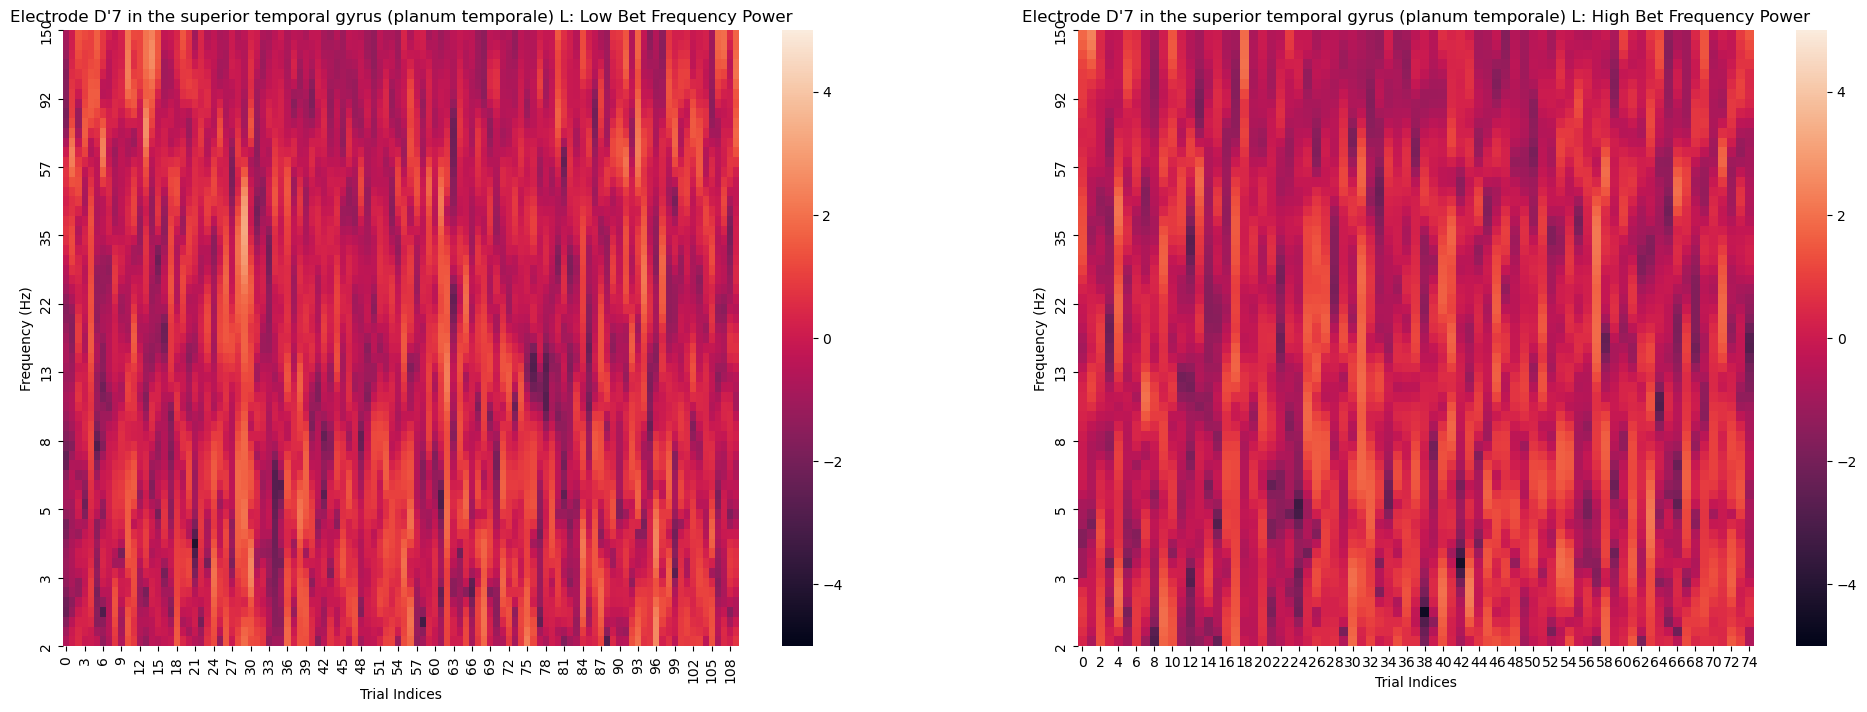

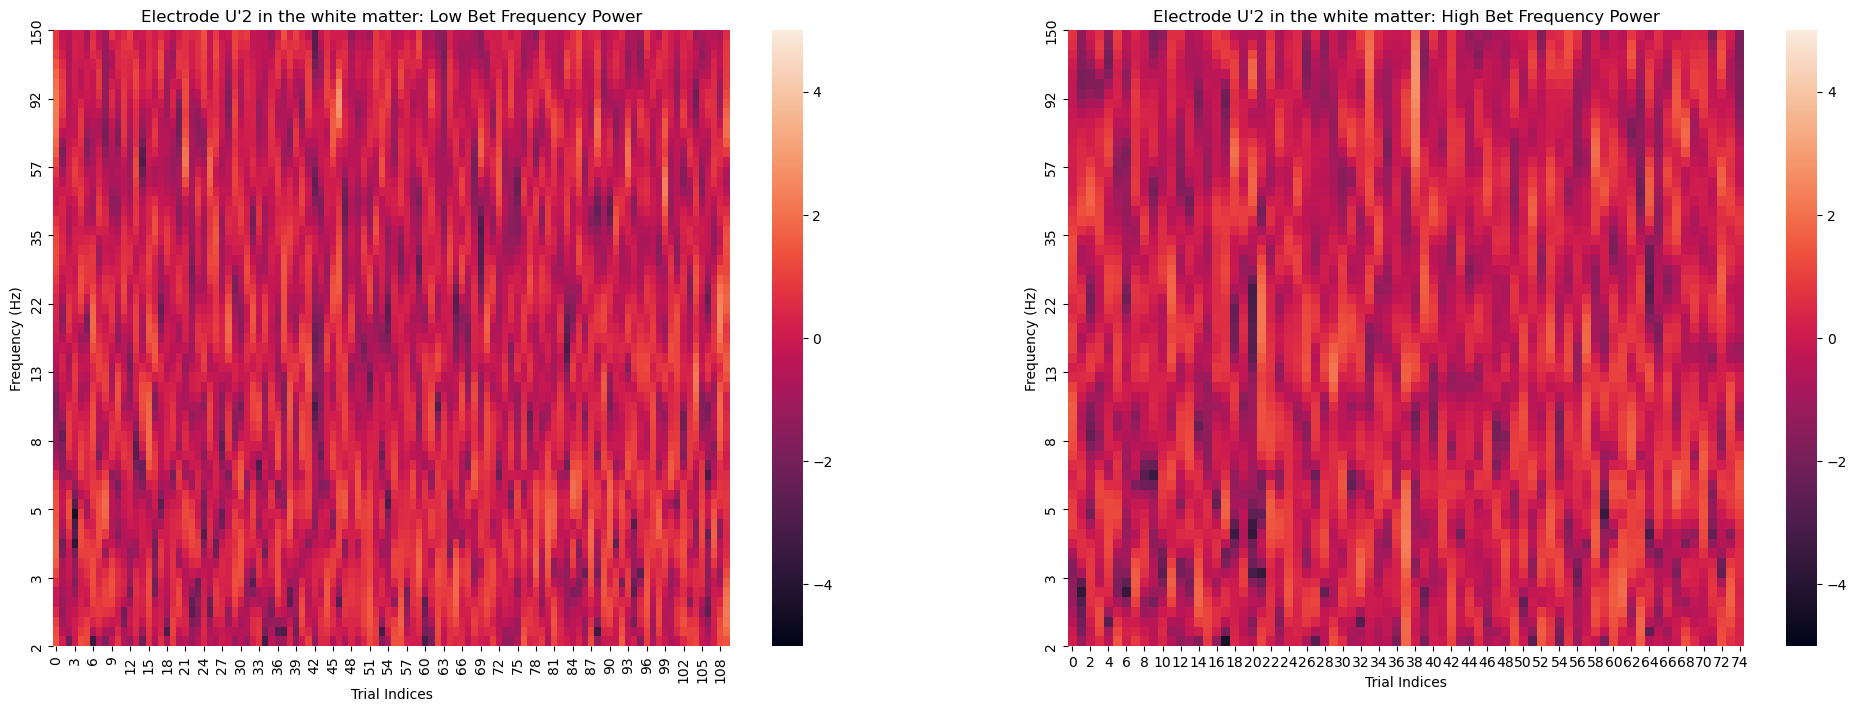

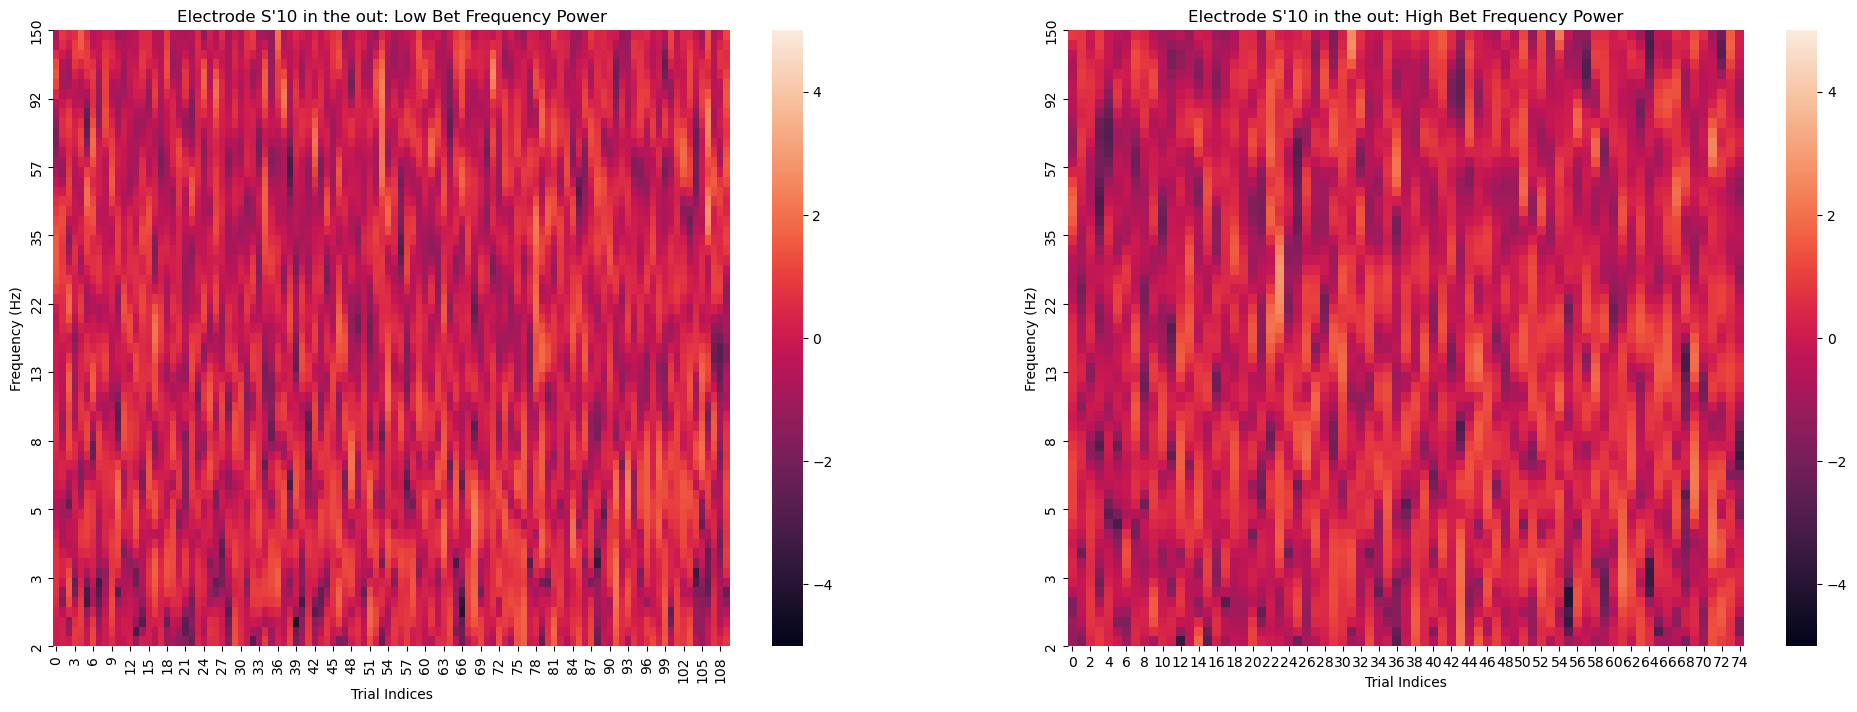

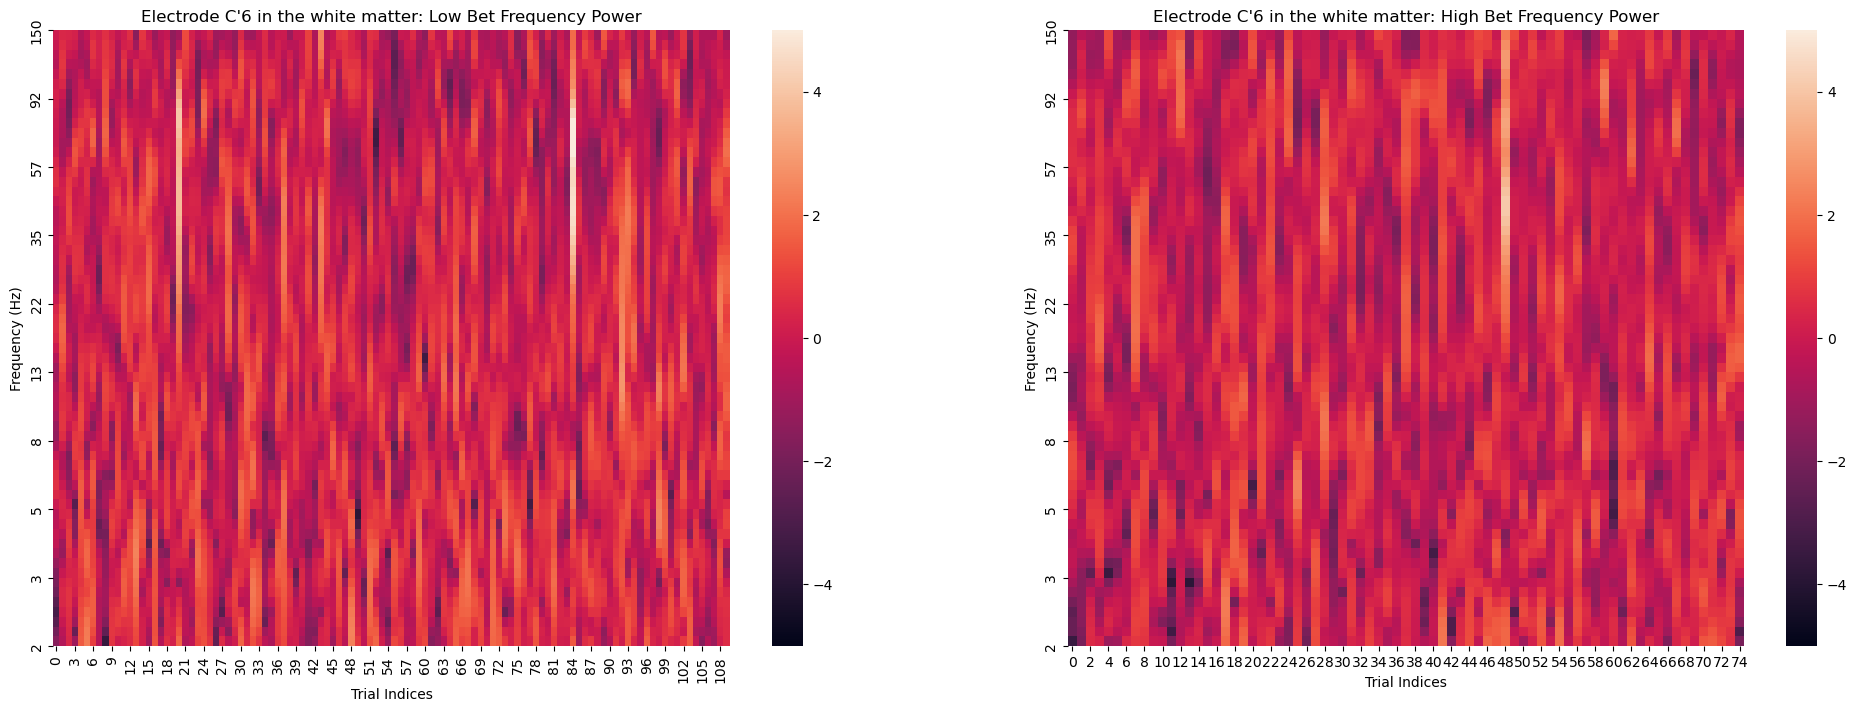

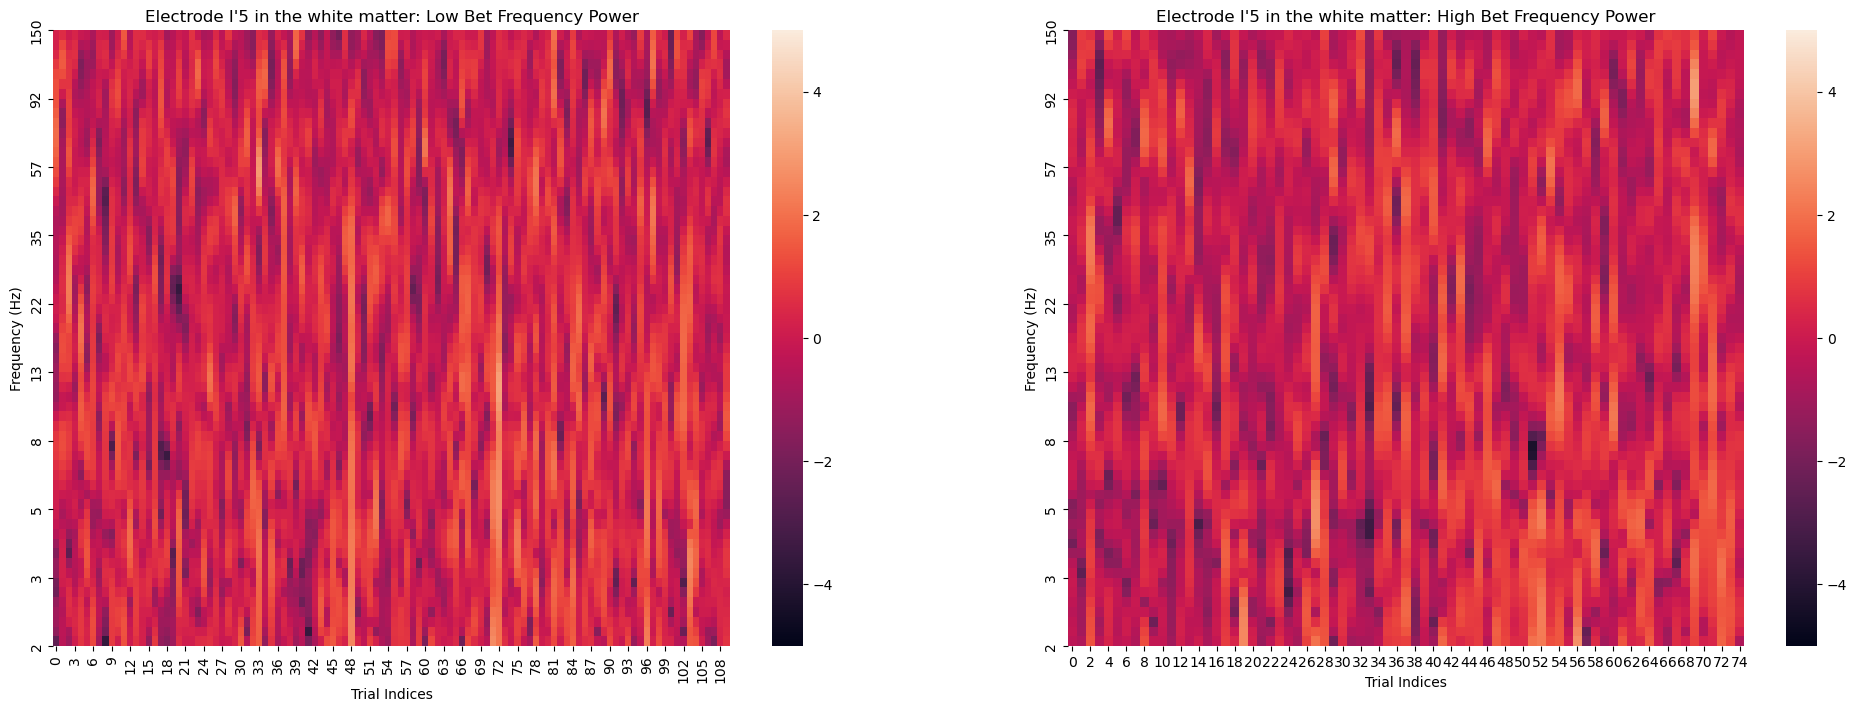

In [113]:
elec_sorted = plot_scores(num_channels, metrics)

In [114]:
elec_sorted


(array(["C'10", "C'8", "F'6", "F'7", "U'9", "D'7", "U'2", "S'10", "C'6",
        "I'5", "I'9", "B'1", "E'3", "B'2", "O'9", "X'8", "B'4", "F'3",
        "F'1", "F'4", "D'1", "E'7", "P'2", "P'3", "P'1", "D'3", "E'6",
        "M'4", "E'2", "E'1", "O'5", "F'8", "R'8", "O'10", "F'5", "M'8",
        "I'10", "I'1", "I'8", "R'9", "D'5", "I'4", "U'7", "C'9", "U'4",
        "U'1", "B'3", "S'4", "X'6", "B'6", "B'7", "C'1", "S'8", "X'3",
        "X'2", "S'9", "B'9", "D'9", "U'10", "F'2", "B'8", "I'6", "D'4",
        "C'5", "D'6", "F'10", "C'4", "C'3", "C'2", "E'4", "E'5", "E'9",
        "E'10", "D'2", "D'10", "D'8", "F'9", "B'10", "I'3", "S'3", "P'7",
        "P'5", "R'4", "R'2", "S'7", "S'6", "S'2", "O'1", "U'8", "U'5",
        "X'10", "X'7", "X'1", 'REF1', "P'8", "R'10", "O'2", "M'3", "I'2",
        "M'10", "M'9", "M'7", "M'6", "M'5", 'REF2', "M'2", "O'3", "R'7",
        "O'6", "P'9", "X'4", "X'5", "B'5", "E'8", "X'9", "O'4", "U'3",
        "P'6", "U'6", "C'7", "R'6", "S'1", "P'4", "I'7", "S'5",

# Extraneous Code